# A transformer-based model based on "What does self-attention learn from Masked Language Modelling?" paper

### Core parts of the transformer
- Separated position and spin
- Single attention layer


### Outline
1. Vanilla attention implementation
2. Factored attention implementation


In [106]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import tqdm
import random
import torch.nn.functional as F

from utils import *
from train import *

In [107]:
X = torch.randn(100,1000,300)
idx = torch.randint(0,1000,(100,))
# create masked_X, Y=model(masked_X)
# X[:,idx,:]-Y[:,idx,:]

In [108]:
# Sequences for decoder
dec_chains_train = np.load('data/final_chains_T=1_num_iters=20_J_experiment_train.npy')
print("Loaded train sequences of proteins sampled from Boltzmann distribution:", dec_chains_train.shape)

dec_chains_test = np.load('data/final_chains_T=1_num_iters=20_J_experiment_test.npy')
print("Loaded test sequences of proteins sampled from Boltzmann distribution:", dec_chains_test.shape)


Loaded train sequences of proteins sampled from Boltzmann distribution: (1000, 200)
Loaded test sequences of proteins sampled from Boltzmann distribution: (1000, 200)


In [109]:
batch_size = 32
train_loader, test_loader = create_dataloaders(dec_chains_train, dec_chains_test, batch_size)

In [110]:
class VanillaAttentionTransformer(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins=3, dropout_rate=0.0):
        super(VanillaAttentionTransformer, self).__init__()
        self.word_embeddings = nn.Linear(num_spins, embed_dim)
        self.position_embeddings = nn.Embedding(max_seq_length, embed_dim)
        self.a = a  # parameter controlling how important positions are
        self.value_weight = nn.Linear(embed_dim, embed_dim)
        self.query_weight = nn.Linear(embed_dim, embed_dim)
        self.key_weight = nn.Linear(embed_dim, embed_dim)
        self.fc = nn.Linear(embed_dim, num_spins)  # output layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, s):
        if not isinstance(s, torch.Tensor):
            s = torch.tensor(s, dtype=torch.float32)

        batch_size, seq_length, num_features = s.shape

        # Ensure position_ids are of shape (batch_size, seq_length)
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0).expand(batch_size, seq_length)
        position_embeddings = self.position_embeddings(position_ids)

        x = self.word_embeddings(s) + self.a * position_embeddings
        
        query = self.query_weight(x)
        key = self.key_weight(x)
        values = self.value_weight(x)
        
        # Simple attention score calculation (Dot product): this is equivalent to the interaction matrix
        scores = torch.matmul(query, key.transpose(-2, -1))  # Transpose last two dimensions for matrix multiplication
        scores = torch.softmax(scores, dim=-1)  # Apply softmax to scores to get probabilities

        # Apply attention scores to values
        attn_output = torch.matmul(scores, values)

        # Apply dropout and the final fully connected layer
        output = self.fc(self.dropout(attn_output))

        return output, scores



In [111]:
def evaluate(model, test_loader, vocab, criterion, device=0):
    model.eval()
    epoch_loss = 0
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    for i, data in tqdm.tqdm(enumerate(test_loader), total=len(test_loader)):
        # Get the inputs
        input_seq = data
        input_one_hot = one_hot_encoding_batch(input_seq.tolist(), vocab)
        # mask a token
        masked_sequence, positions = mask_random_spins_batch(input_seq, vocab=vocab, pos=1, mask_token=2, one_hot_flag=True)
        positions = positions.squeeze(-1)
        # Forward pass
        outputs, attn_weights = model.forward(masked_sequence)
        predictions = [outputs[i][positions[i]] for i in range(positions.shape[0])]
        predictions = torch.stack(predictions)
        
        target_tokens = [input_one_hot[i][positions[i]] for i in range(positions.shape[0])]
        target_tokens = torch.stack(target_tokens)
        target_tokens = torch.where(target_tokens==1)[1]

        # Compute loss
        loss = criterion(predictions, target_tokens)
        epoch_loss += loss.item()
    model.train()
    return epoch_loss / len(test_loader)

def train(model, train_loader, test_loader, vocab, optimizer, criterion, num_epochs=8, device=0):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    # Training loop
    model.train()
    best_eval_loss = 1e-3 # used to do early stopping

    for epoch in tqdm.tqdm(range(num_epochs), leave=False, position=0):
        running_loss = 0
        epoch_loss = 0
        attention_weights = []
        
        for i, data in tqdm.tqdm(enumerate(train_loader), total=len(train_loader), leave=False, position=1):
            # Get the inputs
            input_one_hot = one_hot_encoding_batch(data, vocab)

            # mask a token
            masked_sequence, positions = mask_random_spins_batch(data, vocab=vocab, pos=1, mask_token=2, one_hot_flag=True)
            # Forward pass
            prediction, scores = model.forward(masked_sequence) #masked_sequence[masked_position]
            #predicted_token = F.log_softmax(prediction, dim=-1)
            positions = positions.squeeze(-1)
            target_tokens = [input_one_hot[i][positions[i]] for i in range(positions.shape[0])]
            target_tokens = torch.stack(target_tokens)
            target_tokens = torch.where(target_tokens==1)[1]
            predictions = [prediction[i][positions[i]] for i in range(positions.shape[0])]
            predictions = torch.stack(predictions)
            # Compute loss
            loss = criterion(predictions, target_tokens)
            epoch_loss += loss.item()
            
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            attention_weights.append(scores)
            
            running_loss += loss.item()
            #if i % 10 == 9. :    # print every 10 mini-batches
            #    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            #    running_loss = 0.0

        print(f'Epoch {epoch + 1} | Train Loss: {(epoch_loss / len(data)):.4f}')
        eval_loss = evaluate(model, test_loader, vocab, criterion, device=device)
        print(f'Epoch {epoch + 1} | Eval Loss: {(eval_loss):.4f}')
        
        # Perform early stopping based on eval loss
        if eval_loss < best_eval_loss:
            return epoch_loss / len(train_loader)
    return epoch_loss / len(train_loader), attention_weights


In [112]:
# Define the parameters 
vocab_size = 3
vocab = {-1:0,1:1,2:2} 
L = 200
embedding_dim = 200
hidden_dim = 400
num_layers = 1 # have to adapt the model for 2 and 3 layers
dropout_rate = 0.0
lr = 1e-3
num_sequences = 1000
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [113]:
# Example usage:
model = VanillaAttentionTransformer(embed_dim=embedding_dim, a=0, max_seq_length=L, num_spins=3, dropout_rate=dropout_rate)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss, attn_weights = train(model, train_loader, test_loader, vocab, optimizer, criterion, device=device)
#torch.save(model.state_dict(), 'models/lstm_scratch.pt')
#evaluate(model, test_dataloader, criterion, device=device)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 2.9669


 12%|█▎        | 1/8 [00:04<00:33,  4.81s/it]

Epoch 1 | Eval Loss: 0.6401


Epoch 2 | Train Loss: 2.7931


 25%|██▌       | 2/8 [00:09<00:28,  4.75s/it]

Epoch 2 | Eval Loss: 0.5599


Epoch 3 | Train Loss: 2.8312


 38%|███▊      | 3/8 [00:14<00:23,  4.74s/it]

Epoch 3 | Eval Loss: 0.5430


Epoch 4 | Train Loss: 2.8696


 50%|█████     | 4/8 [00:19<00:19,  4.80s/it]

Epoch 4 | Eval Loss: 0.6826


Epoch 5 | Train Loss: 2.7979


 62%|██████▎   | 5/8 [00:23<00:14,  4.80s/it]

Epoch 5 | Eval Loss: 0.6108


Epoch 6 | Train Loss: 2.7965


 75%|███████▌  | 6/8 [00:28<00:09,  4.75s/it]

Epoch 6 | Eval Loss: 0.6792


Epoch 7 | Train Loss: 2.7925


 88%|████████▊ | 7/8 [00:33<00:04,  4.72s/it]

Epoch 7 | Eval Loss: 0.6893


Epoch 8 | Train Loss: 2.8089


100%|██████████| 32/32 [00:02<00:00, 15.14it/s]
                                             

Epoch 8 | Eval Loss: 0.6613


In [102]:
# To save only the decoder layer weights
attn_weights = torch.vstack(attn_weights)
torch.save(attn_weights, 'model_decoder/transformer_cross_attn_weights.pth')

# If you need to load these weights later
decoder_weights = torch.load('model_decoder/transformer_cross_attn_weights.pth')
print(decoder_weights.shape)
print(dec_chains_test.shape)

torch.Size([1000, 200, 200])
(1000, 200)


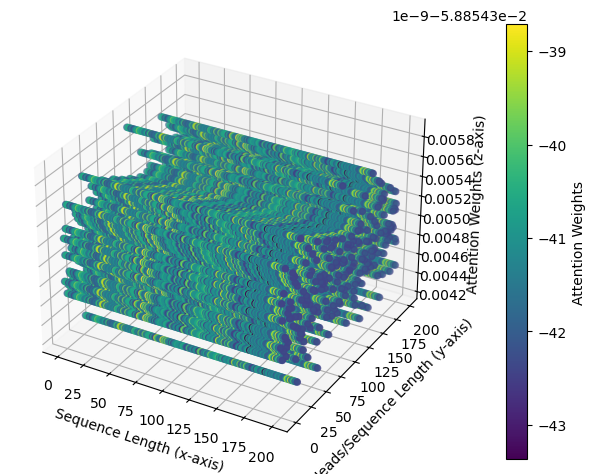

In [114]:
# loading self-attention weights)
caw = decoder_weights.mean(0).cpu().detach().numpy()

# Create a meshgrid for x and y axes
x = np.arange(caw.shape[0])
y = np.arange(caw.shape[1])
x, y = np.meshgrid(x, y)

# Create a meshgrid for x and y axes
x = np.arange(caw.shape[0])
y = np.arange(caw.shape[1])
x, y = np.meshgrid(x, y)

# Transpose the meshgrid to match the shape of attention_weights
x = x.T
y = y.T

# Flatten the x, y, and z (attention_weights) for plotting
x = x.flatten()
y = y.flatten()
z = caw.flatten()

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colormap
# third distribution is more aligned one
sc = ax.scatter(x, y, z, c=np.dot(caw,dec_chains_test[:200,:]), cmap='viridis')

# Add a colorbar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Attention Weights')

# Labels
ax.set_xlabel('Sequence Length (x-axis)')
ax.set_ylabel('Heads/Sequence Length (y-axis)')
ax.set_zlabel('Attention Weights (z-axis)')


plt.tight_layout()
plt.show()


### Determine the J from the decoder weights
Ideas:
- To achieve that we set the negative weights equal to 0 and positive to 1

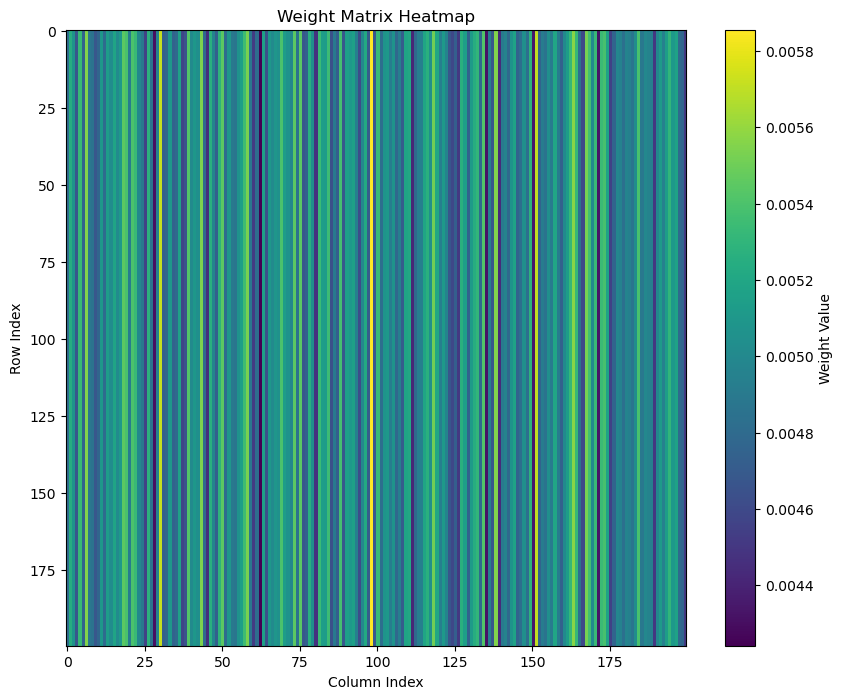

In [115]:
def generate_heatmap(weight_matrix):
    """
    Generates a heatmap from a given weight matrix.
    
    Parameters:
    weight_matrix (numpy.ndarray): A 2D numpy array of shape (200, 200) representing the weights.
    
    Returns:
    None
    """
    if weight_matrix.shape != (200, 200):
        raise ValueError("The weight matrix must be of shape (200, 200)")
    
    plt.figure(figsize=(10, 8))
    plt.imshow(weight_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label='Weight Value')
    plt.title('Weight Matrix Heatmap')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()

# Example usage
#caw = decoder_weights.cpu().detach().numpy()
generate_heatmap(caw)

## With feed-forward network
The way it is implemented in the masked nlp paper

In [116]:
# Sequences for decoder
dec_chains_train = np.load('final_chains_T=1_num_iters=20_J_experiment_train.npy')
print("Loaded train sequences of proteins sampled from Boltzmann distribution:", dec_chains_train.shape)

dec_chains_test = np.load('final_chains_T=1_num_iters=20_J_experiment_test.npy')
print("Loaded test sequences of proteins sampled from Boltzmann distribution:", dec_chains_test.shape)

batch_size = 32
train_loader, test_loader = create_dataloaders(dec_chains_train, dec_chains_test, batch_size)

FileNotFoundError: [Errno 2] No such file or directory: 'final_chains_T=1_num_iters=20_J_experiment_train.npy'

In [117]:
class VanillaAttentionTransformer(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins=3, dropout_rate=0.0):
        super(VanillaAttentionTransformer, self).__init__()
        self.value_weight = nn.Linear(embed_dim, embed_dim)
        self.query_weight = nn.Linear(embed_dim, embed_dim)
        self.key_weight = nn.Linear(embed_dim, embed_dim)
        self.fc = nn.Linear(embed_dim, embed_dim)  # output layer
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        query = self.query_weight(x)
        key = self.key_weight(x)
        values = self.value_weight(x)
        
        # Simple attention score calculation (Dot product): this is equivalent to the interaction matrix
        scores = torch.matmul(query, key.transpose(-2, -1))  # Transpose last two dimensions for matrix multiplication
        scores = torch.softmax(scores, dim=-1)  # Apply softmax to scores to get probabilities

        # Apply attention scores to values
        attn_output = torch.matmul(scores, values)
        output = self.fc(self.dropout(attn_output))
        return output, scores

class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_hidden):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_hidden)
        self.fc2 = nn.Linear(d_hidden, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [118]:
class SimpleTransformer(nn.Module):
    def __init__(self, embed_dim, hidden_dim, a, max_seq_length, num_spins=3, dropout_rate=0.0):
        super(SimpleTransformer, self).__init__()
        self.word_embeddings = nn.Linear(num_spins, embed_dim)
        self.position_embeddings = nn.Embedding(max_seq_length, embed_dim)
        self.a = a
        self.feed_forward = PositionWiseFeedForward(embed_dim, hidden_dim)
        self.attention = VanillaAttentionTransformer(embed_dim, a, max_seq_length, num_spins, dropout_rate)
    
    def forward(self, s):
        if not isinstance(s, torch.Tensor):
            s = torch.tensor(s, dtype=torch.float32)
        batch_size, seq_length, num_features = s.shape
        # Ensure position_ids are of shape (batch_size, seq_length)
        position_ids = torch.arange(seq_length, dtype=torch.long).unsqueeze(0).expand(batch_size, seq_length)
        position_embeddings = self.position_embeddings(position_ids)
        x = self.word_embeddings(s) + self.a * position_embeddings
        x, attn_weights = self.attention(x)
        output = self.feed_forward(x)
        return output, attn_weights


In [119]:
def evaluate(model, test_loader, vocab, criterion, device=0):
    model.eval()
    epoch_loss = 0
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    for i, data in tqdm.tqdm(enumerate(test_loader), total=len(test_loader)):
        # Get the inputs
        input_seq = data
        input_one_hot = one_hot_encoding_batch(input_seq.tolist(), vocab)
        # mask a token
        masked_sequence, positions = mask_random_spins_batch(input_seq, vocab=vocab, pos=1, mask_token=2, one_hot_flag=True)
        positions = positions.squeeze(-1)
        # Forward pass
        outputs, attn_weights = model.forward(masked_sequence)
        predictions = [outputs[i][positions[i]] for i in range(positions.shape[0])]
        predictions = torch.stack(predictions)
        
        target_tokens = [input_one_hot[i][positions[i]] for i in range(positions.shape[0])]
        target_tokens = torch.stack(target_tokens)
        target_tokens = torch.where(target_tokens==1)[1]

        # Compute loss
        loss = criterion(predictions, target_tokens)
        epoch_loss += loss.item()
    model.train()
    return epoch_loss / len(test_loader)

def train(model, train_loader, test_loader, vocab, optimizer, criterion, num_epochs=50, device=0):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    # Training loop
    model.train()
    best_eval_loss = 1e-3 # used to do early stopping

    for epoch in tqdm.tqdm(range(num_epochs), leave=False, position=0):
        running_loss = 0
        epoch_loss = 0
        attention_weights = []
        
        for i, data in tqdm.tqdm(enumerate(train_loader), total=len(train_loader), leave=False, position=1):
            # Get the inputs
            input_one_hot = one_hot_encoding_batch(data, vocab)

            # mask a token
            masked_sequence, positions = mask_random_spins_batch(data, vocab=vocab, pos=1, mask_token=2, one_hot_flag=True)
            # Forward pass
            prediction, scores = model.forward(masked_sequence) #masked_sequence[masked_position]
            #predicted_token = F.log_softmax(prediction, dim=-1)
            positions = positions.squeeze(-1)
            target_tokens = [input_one_hot[i][positions[i]] for i in range(positions.shape[0])]
            target_tokens = torch.stack(target_tokens)
            target_tokens = torch.where(target_tokens==1)[1]
            predictions = [prediction[i][positions[i]] for i in range(positions.shape[0])]
            predictions = torch.stack(predictions)
            # Compute loss
            loss = criterion(predictions, target_tokens)
            epoch_loss += loss.item()
            
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            attention_weights.append(scores)
            
            running_loss += loss.item()
            #if i % 10 == 9. :    # print every 10 mini-batches
            #    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            #    running_loss = 0.0

        print(f'Epoch {epoch + 1} | Train Loss: {(epoch_loss / len(data)):.4f}')
        eval_loss = evaluate(model, test_loader, vocab, criterion, device=device)
        print(f'Epoch {epoch + 1} | Eval Loss: {(eval_loss):.4f}')
        
        # Perform early stopping based on eval loss
        if eval_loss < best_eval_loss:
            return epoch_loss / len(train_loader)
    return epoch_loss / len(train_loader), attention_weights


In [120]:
# Define the parameters 
vocab_size = 3
vocab = {-1:0,1:1,2:2} 
L = 200
embedding_dim = 20
hidden_dim = 400
num_layers = 1 # have to adapt the model for 2 and 3 layers
dropout_rate = 0.0
lr = 1e-2
num_sequences = 1000
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [121]:
# Example usage:
model = SimpleTransformer(embed_dim=embedding_dim, hidden_dim=hidden_dim, a=1, max_seq_length=L, num_spins=3, dropout_rate=dropout_rate)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

loss, attn_weights = train(model, train_loader, test_loader, vocab, optimizer, criterion, device=device)
#torch.save(model.state_dict(), 'models/lstm_scratch.pt')
#evaluate(model, test_dataloader, criterion, device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 2.1679


  2%|▏         | 1/50 [00:04<03:43,  4.56s/it]

Epoch 1 | Eval Loss: 0.1015


Epoch 2 | Train Loss: 0.8302


  4%|▍         | 2/50 [00:08<03:34,  4.47s/it]

Epoch 2 | Eval Loss: 0.0280


Epoch 3 | Train Loss: 0.9009


  6%|▌         | 3/50 [00:13<03:28,  4.45s/it]

Epoch 3 | Eval Loss: 0.0407


Epoch 4 | Train Loss: 0.8010


  8%|▊         | 4/50 [00:17<03:24,  4.45s/it]

Epoch 4 | Eval Loss: 0.0672


Epoch 5 | Train Loss: 0.6917


 10%|█         | 5/50 [00:22<03:20,  4.44s/it]

Epoch 5 | Eval Loss: 0.0403


Epoch 6 | Train Loss: 0.9419


 12%|█▏        | 6/50 [00:26<03:17,  4.49s/it]

Epoch 6 | Eval Loss: 0.0281


Epoch 7 | Train Loss: 0.6932


 14%|█▍        | 7/50 [00:31<03:11,  4.46s/it]

Epoch 7 | Eval Loss: 0.0107


Epoch 8 | Train Loss: 0.6428


 16%|█▌        | 8/50 [00:35<03:06,  4.44s/it]

Epoch 8 | Eval Loss: 0.0531


Epoch 9 | Train Loss: 0.6297


 18%|█▊        | 9/50 [00:40<03:01,  4.43s/it]

Epoch 9 | Eval Loss: 0.0745


Epoch 10 | Train Loss: 0.7161


 20%|██        | 10/50 [00:44<02:57,  4.43s/it]

Epoch 10 | Eval Loss: 0.0480


Epoch 11 | Train Loss: 0.5571


 22%|██▏       | 11/50 [00:48<02:53,  4.45s/it]

Epoch 11 | Eval Loss: 0.0180


Epoch 12 | Train Loss: 0.5867


 24%|██▍       | 12/50 [00:53<02:49,  4.45s/it]

Epoch 12 | Eval Loss: 0.0342


Epoch 13 | Train Loss: 0.7051


 26%|██▌       | 13/50 [00:57<02:45,  4.47s/it]

Epoch 13 | Eval Loss: 0.0631


Epoch 14 | Train Loss: 0.8500


 28%|██▊       | 14/50 [01:02<02:40,  4.47s/it]

Epoch 14 | Eval Loss: 0.0940


Epoch 15 | Train Loss: 0.8356


 30%|███       | 15/50 [01:06<02:36,  4.46s/it]

Epoch 15 | Eval Loss: 0.0359


Epoch 16 | Train Loss: 0.5374


 32%|███▏      | 16/50 [01:11<02:31,  4.46s/it]

Epoch 16 | Eval Loss: 0.0253


Epoch 17 | Train Loss: 0.6314


 34%|███▍      | 17/50 [01:15<02:27,  4.48s/it]

Epoch 17 | Eval Loss: 0.0359


Epoch 18 | Train Loss: 0.6201


 36%|███▌      | 18/50 [01:20<02:23,  4.49s/it]

Epoch 18 | Eval Loss: 0.0868


Epoch 19 | Train Loss: 0.6529


 38%|███▊      | 19/50 [01:24<02:19,  4.51s/it]

Epoch 19 | Eval Loss: 0.0516


Epoch 20 | Train Loss: 0.6904


 40%|████      | 20/50 [01:29<02:14,  4.49s/it]

Epoch 20 | Eval Loss: 0.0530


Epoch 21 | Train Loss: 0.6136


 42%|████▏     | 21/50 [01:33<02:10,  4.50s/it]

Epoch 21 | Eval Loss: 0.0217


Epoch 22 | Train Loss: 0.7420


 44%|████▍     | 22/50 [01:38<02:05,  4.49s/it]

Epoch 22 | Eval Loss: 0.0254


Epoch 23 | Train Loss: 0.5325


 46%|████▌     | 23/50 [01:42<02:01,  4.48s/it]

Epoch 23 | Eval Loss: 0.0252


Epoch 24 | Train Loss: 0.5184


 48%|████▊     | 24/50 [01:47<01:56,  4.47s/it]

Epoch 24 | Eval Loss: 0.0182


Epoch 25 | Train Loss: 0.4540


 50%|█████     | 25/50 [01:51<01:52,  4.48s/it]

Epoch 25 | Eval Loss: 0.0204


Epoch 26 | Train Loss: 0.6625


 52%|█████▏    | 26/50 [01:56<01:47,  4.48s/it]

Epoch 26 | Eval Loss: 0.0390


Epoch 27 | Train Loss: 0.5909


 54%|█████▍    | 27/50 [02:00<01:42,  4.48s/it]

Epoch 27 | Eval Loss: 0.0512


Epoch 28 | Train Loss: 0.6274


 56%|█████▌    | 28/50 [02:05<01:38,  4.50s/it]

Epoch 28 | Eval Loss: 0.0160


Epoch 29 | Train Loss: 0.5641


 58%|█████▊    | 29/50 [02:09<01:35,  4.53s/it]

Epoch 29 | Eval Loss: 0.0119


Epoch 30 | Train Loss: 0.7124


 60%|██████    | 30/50 [02:14<01:30,  4.51s/it]

Epoch 30 | Eval Loss: 0.0289


Epoch 31 | Train Loss: 0.5671


 62%|██████▏   | 31/50 [02:18<01:25,  4.53s/it]

Epoch 31 | Eval Loss: 0.0374


Epoch 32 | Train Loss: 0.5418


 64%|██████▍   | 32/50 [02:23<01:20,  4.50s/it]

Epoch 32 | Eval Loss: 0.0142


Epoch 33 | Train Loss: 0.7894


 66%|██████▌   | 33/50 [02:27<01:16,  4.49s/it]

Epoch 33 | Eval Loss: 0.0303


Epoch 34 | Train Loss: 0.4710


 68%|██████▊   | 34/50 [02:32<01:11,  4.47s/it]

Epoch 34 | Eval Loss: 0.0250


Epoch 35 | Train Loss: 0.7110


 70%|███████   | 35/50 [02:36<01:06,  4.46s/it]

Epoch 35 | Eval Loss: 0.0224


Epoch 36 | Train Loss: 0.5403


 72%|███████▏  | 36/50 [02:41<01:02,  4.47s/it]

Epoch 36 | Eval Loss: 0.0279


Epoch 37 | Train Loss: 0.7382


 74%|███████▍  | 37/50 [02:45<00:57,  4.46s/it]

Epoch 37 | Eval Loss: 0.0637


Epoch 38 | Train Loss: 0.6139


 76%|███████▌  | 38/50 [02:50<00:53,  4.47s/it]

Epoch 38 | Eval Loss: 0.0231


Epoch 39 | Train Loss: 0.7791


 78%|███████▊  | 39/50 [02:54<00:49,  4.47s/it]

Epoch 39 | Eval Loss: 0.0452


Epoch 40 | Train Loss: 0.5835


 80%|████████  | 40/50 [02:58<00:44,  4.47s/it]

Epoch 40 | Eval Loss: 0.0274


Epoch 41 | Train Loss: 0.5257


 82%|████████▏ | 41/50 [03:03<00:40,  4.47s/it]

Epoch 41 | Eval Loss: 0.0335


Epoch 42 | Train Loss: 0.6794


 84%|████████▍ | 42/50 [03:07<00:35,  4.48s/it]

Epoch 42 | Eval Loss: 0.0580


Epoch 43 | Train Loss: 0.7504


 86%|████████▌ | 43/50 [03:12<00:31,  4.52s/it]

Epoch 43 | Eval Loss: 0.0593


Epoch 44 | Train Loss: 0.6924


 88%|████████▊ | 44/50 [03:17<00:27,  4.51s/it]

Epoch 44 | Eval Loss: 0.0477


Epoch 45 | Train Loss: 0.6186


 90%|█████████ | 45/50 [03:21<00:22,  4.49s/it]

Epoch 45 | Eval Loss: 0.0342


Epoch 46 | Train Loss: 0.7113


 92%|█████████▏| 46/50 [03:25<00:17,  4.49s/it]

Epoch 46 | Eval Loss: 0.0238


Epoch 47 | Train Loss: 0.5523


 94%|█████████▍| 47/50 [03:30<00:13,  4.47s/it]

Epoch 47 | Eval Loss: 0.0554


Epoch 48 | Train Loss: 0.7504


 96%|█████████▌| 48/50 [03:34<00:08,  4.47s/it]

Epoch 48 | Eval Loss: 0.0332


Epoch 49 | Train Loss: 0.5104


 98%|█████████▊| 49/50 [03:39<00:04,  4.47s/it]

Epoch 49 | Eval Loss: 0.0508


Epoch 50 | Train Loss: 0.7164


100%|██████████| 32/32 [00:02<00:00, 15.77it/s]
                                               

Epoch 50 | Eval Loss: 0.0285


In [122]:
attn_weights = torch.vstack(attn_weights)
# To save only the decoder layer weights
torch.save(attn_weights, 'model_decoder/transformer_cross_attn_weights.pth')

# If you need to load these weights later
decoder_weights = torch.load('model_decoder/transformer_cross_attn_weights.pth')
print(decoder_weights.shape)
print(dec_chains_test.shape)

torch.Size([1000, 200, 200])
(1000, 200)


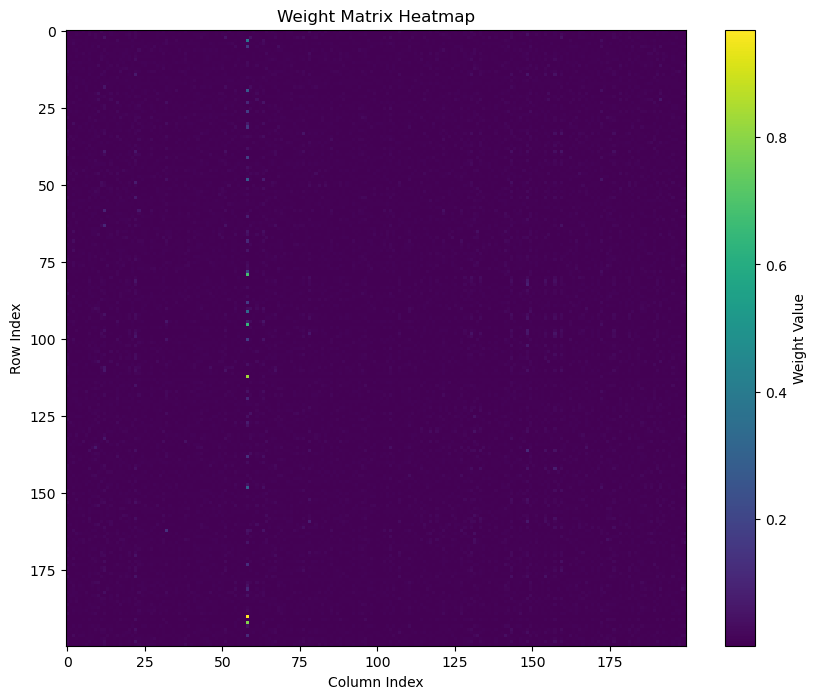

In [127]:
caw = decoder_weights[-100].cpu().detach().numpy()
generate_heatmap(caw)

To fully reproduce results we should consider vocabulary of 20 (equal to number of amino acids)

## Previous implementations

In [198]:
class VanillaAttentionTransformer(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins=3, dropout_rate=0.0):
        super(VanillaAttentionTransformer, self).__init__()
        self.word_embeddings = nn.Linear(num_spins, embed_dim)
        self.position_embeddings = nn.Embedding(max_seq_length, embed_dim)
        self.a = a # parameter controlling how important are positions
        self.value_weight = nn.Linear(embed_dim, embed_dim)
        self.query_weight = nn.Linear(embed_dim, embed_dim)
        self.key_weight = nn.Linear(embed_dim, embed_dim)
        self.fc = nn.Linear(embed_dim, num_spins) # output layer
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, s, masked_token):
        position_ids = torch.arange(len(s), dtype=torch.long)
        position_ids = position_ids
        s = torch.tensor(s, dtype=torch.float)
        masked_token = torch.tensor(masked_token, dtype=torch.float)
        #print("the sequence with the masked token:", s)
        print("shape of position ids before embedding:", position_ids.shape)
        print("shape the sequence with the masked token:", s.shape)
        print("value of the word embedding:", self.word_embeddings(s).shape)
        print("positional embedding:", self.position_embeddings(position_ids))
        x = self.word_embeddings(s) + self.position_embeddings(position_ids)
        query = self.query_weight(x)
        key = self.key_weight(x)

        values = self.value_weight(self.word_embeddings(s) + self.a*self.position_embeddings(position_ids)) # (batch_size,embed_dim)
        exp_scaling = torch.exp(self.word_embeddings(masked_token) + self.position_embeddings(position_ids).T@query.T@key@(self.word_embeddings(s) + self.a*self.position_embeddings(position_ids)))
        attn_output = torch.sum(exp_scaling/torch.sum(exp_scaling.sum(0))*values) # not sure it multiplies the way I want it to multiply - check
        output = self.dropout(self.fc(attn_output))
        return output
    
class FactoredAttentionTransformer(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins=3, dropout_rate=0.0):
        super(FactoredAttentionTransformer, self).__init__()
        self.word_embeddings = nn.Embedding(num_spins, embed_dim)
        self.word_embedding.weight.requires_grad = False
        self.position_embeddings = nn.Embedding(max_seq_length, embed_dim)
        self.a = a # parameter controlling how important are positions
        self.value_weight = nn.Linear(embed_dim, embed_dim)
        self.query_weight = nn.Linear(embed_dim, embed_dim)
        self.key_weight = nn.Linear(embed_dim, embed_dim)
        self.fc = nn.Linear(embed_dim, num_spins) # output layer
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, s, masked_token):
        # masked token should be equal to 0
        # masked_token = torch.tensor([0])
        position_ids = torch.arange(len(s), dtype=torch.long)
        position_ids = position_ids
        x = self.word_embeddings(s) + self.position_embeddings(position_ids)
        query = self.query_weight(x)
        key = self.key_weight(x)

        values = self.value_weight(self.word_embeddings(s)) # (embed_dim)
        exp_scaling = torch.exp(self.word_embeddings(masked_token) + self.position_embeddings(position_ids).T@query.T@key@(self.word_embeddings(s) + self.a*self.position_embeddings(position_ids)))
        attn_output = torch.sum(exp_scaling/torch.sum(exp_scaling.sum(0))*values) # not sure it multiplies the way I want it to multiply - check
        output = self.fc(self.dropout(attn_output))
        return output